# Explainable Detection of Pneumonia in Chest X-rays using InceptionV3 and Grad-CAM

## Introduction
In recent years, advancements in deep learning and computer vision have paved the way for innovative solutions in medical image analysis. One such application is the detection of pneumonia in chest X-ray images, a task critical for timely diagnosis and treatment. In this notebook, I take a deep dive into the practical aspects of transfer learning techniques, specifically fine-tuning the InceptionV3 convolutional neural network using PyTorch. Transfer learning allows us to utilize pre-trained models, trained on large-scale datasets like ImageNet, and adapt them to specific tasks with relatively small amounts of data. Additionally, I will be exploring Grad-CAM (Gradient-weighted Class Activation Mapping) for enhancing model explainability, shedding light on the regions of the X-ray images contributing most to the model's predictions. Through this project, I aim to provide a hands-on understanding of how these techniques can be applied in real-world scenarios, fostering learning in the domains of transfer learning, computer vision, and model explainability.

<h1 id="imports" style="font-family:verdana;"> 
    <center>
        Imports and Installations
    </center>
</h1>

In [1]:
!pip install -q grad-cam

In [2]:
from PIL import Image
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
from typing import Tuple
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import torch.optim as optim
import torch.nn as nn
import torch
import numpy as np
import random
import warnings
import shutil
import os

warnings.filterwarnings('ignore')
matplotlib.style.use('ggplot')

In [3]:
# For reproducibility
seed = 27
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

<h1 id="loading-and-analyzing-the-dataset" style="font-family:verdana;"> 
    <center>
        Loading and Analyzing the Dataset
    </center>
</h1>

## About the Dataset

- The dataset consists of 5,863 chest X-ray images organized into three folders for training, testing, and validation. 
- Each image falls into one of two categories: Pneumonia or Normal. However, it is worth noting that the dataset from the original research is actually used to classify different types of Pneumonia.
- The images were selected from pediatric patients aged one to five years old at Guangzhou Women and Children’s Medical Center and have undergone grading by two expert physicians, with a third expert checking the evaluation set to ensure accuracy and account for any grading errors.

In [4]:
dataset_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/'

train_path = f'{dataset_path}/train/'
val_path = f'{dataset_path}/val/'
test_path = f'{dataset_path}/test/'

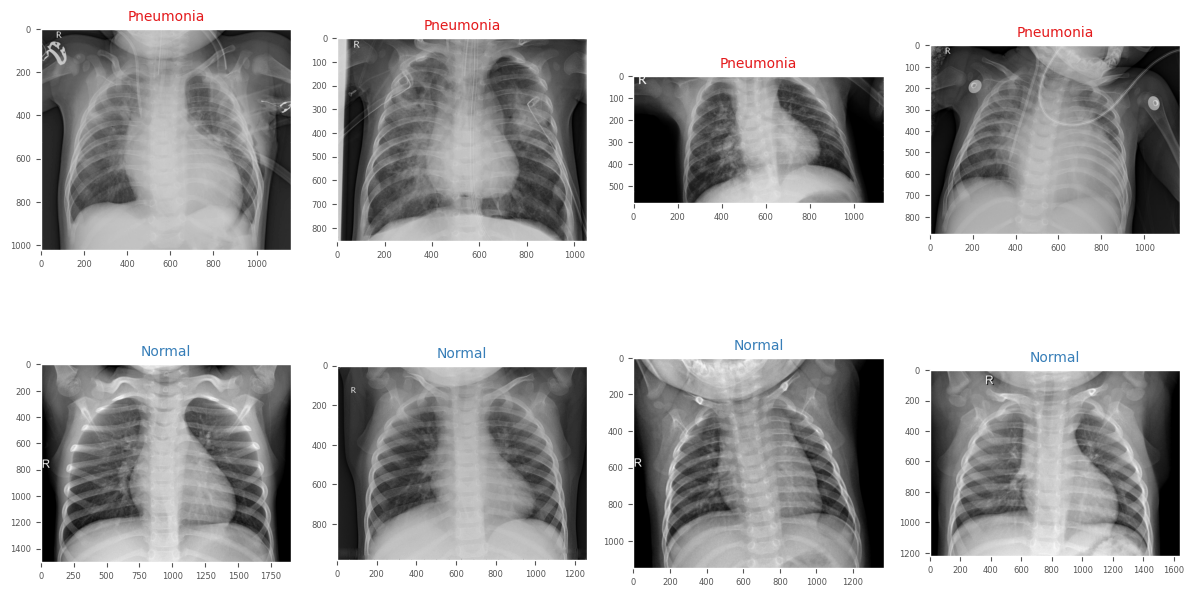

In [5]:
random_pneumonia_samples = random.sample(os.listdir(f'{train_path}/PNEUMONIA'), 4)
random_non_pneumonia_samples = random.sample(os.listdir(f'{train_path}/NORMAL'), 4)

plt.rcParams['axes.grid'] = False
colors = sns.color_palette('Set1', 2)
fig, ax = plt.subplots(2, 4, figsize=(12, 7))
ax = ax.flatten()

for i in range(4):
    filename = random_pneumonia_samples[i]
    image = Image.open(f'{train_path}/PNEUMONIA/{filename}')
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title('Pneumonia', color=colors[0], fontsize=10)
    ax[i].tick_params(axis='both', which='major', labelsize=6)

for i in range(4, 8):
    filename = random_non_pneumonia_samples[i-5]
    image = Image.open(f'{train_path}/NORMAL/{filename}')
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title('Normal', color=colors[1], fontsize=10)
    ax[i].tick_params(axis='both', which='major', labelsize=6)


plt.tight_layout()
plt.show()

In [6]:
def plot_label_distribution(train_path: str, val_path: str, test_path: str) -> None:
    plt.rcParams['axes.grid'] = True
    train_counts = [len(os.listdir(f'{train_path}/{cls}')) for cls in ['NORMAL', 'PNEUMONIA']]
    val_counts = [len(os.listdir(f'{val_path}/{cls}')) for cls in ['NORMAL', 'PNEUMONIA']]
    test_counts = [len(os.listdir(f'{test_path}/{cls}')) for cls in ['NORMAL', 'PNEUMONIA']]
    total_counts = [sum(x) for x in zip(train_counts, val_counts, test_counts)]

    total_train = sum(train_counts)
    total_val = sum(val_counts)
    total_test = sum(test_counts)
    total_images = sum(total_counts)

    fig, ax = plt.subplots(1, 4, figsize=(14, 5))
    bars0 = ax[0].bar(['Normal', 'Pneumonia'], train_counts, color=colors)
    ax[0].set_title('Train')
    ax[0].set_ylabel('Number of images')
    bars1 = ax[1].bar(['Normal', 'Pneumonia'], val_counts, color=colors)
    ax[1].set_title('Validation')
    bars2 = ax[2].bar(['Normal', 'Pneumonia'], test_counts, color=colors)
    ax[2].set_title('Test')
    bars3 = ax[3].bar(['Normal', 'Pneumonia'], total_counts, color=colors)
    ax[3].set_title('Total')

    def add_labels(bars, ax, total):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height,
                    f'{height} ({height / total:.1%})',
                    ha='center', va='bottom')

    add_labels(bars0, ax[0], total_train)
    add_labels(bars1, ax[1], total_val)
    add_labels(bars2, ax[2], total_test)
    add_labels(bars3, ax[3], total_images)

    plt.tight_layout()
    plt.show()

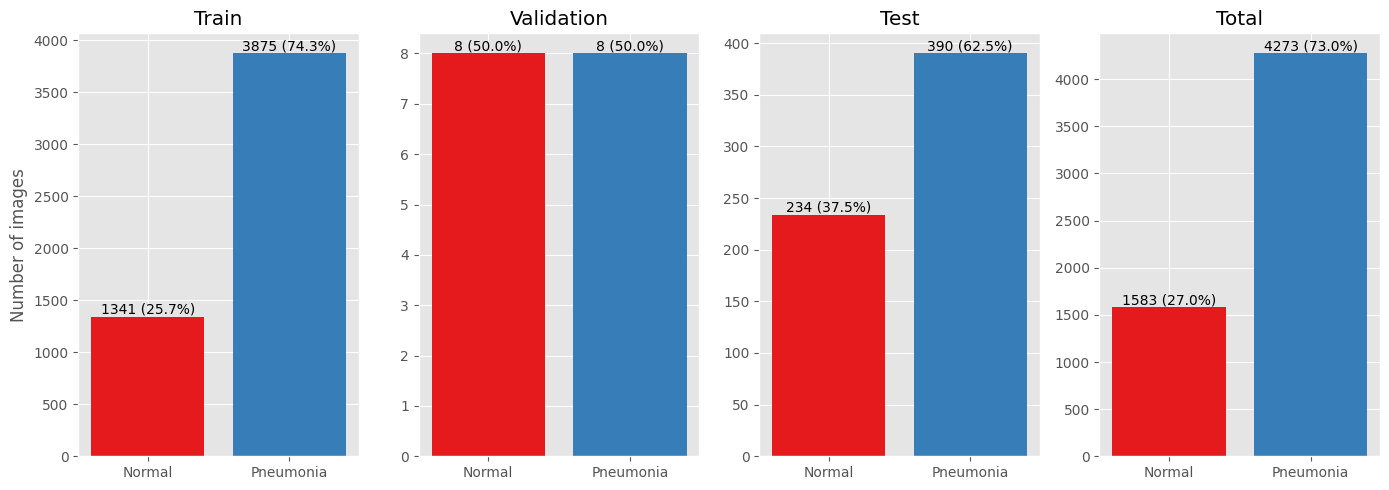

In [7]:
plot_label_distribution(train_path, val_path, test_path)

## Re-splitting the dataset

- The dataset does not seem to be split correctlyas there are only 16 samples in the validation set, 8 of each class.
- To fix this issue, I decided to combine all images and split them into training, validation, and test tests myself using a ratio of 80-10-10
- The re-split version of the dataset is not balanced, however the balance relative to the whole dataset is preserved in each of the subsets. The plot below shows the number of samples of each class in each set after re-splitting.

In [8]:
new_dataset_path = '/kaggle/working/chest_xray_new/'
new_train_path = f'{new_dataset_path}/train/'
new_val_path = f'{new_dataset_path}/val/'
new_test_path = f'{new_dataset_path}/test/'

if not os.path.exists(new_dataset_path):
    for split in ['train', 'val', 'test']:
        for cls in ['NORMAL', 'PNEUMONIA']:
            os.makedirs(f'{new_dataset_path}/{split}/{cls}', exist_ok=True)
            
    for cls in ['NORMAL', 'PNEUMONIA']:
        all_files = []
        for split in ['train', 'val', 'test']:
            source_folder = f'{dataset_path}/{split}/{cls}'
            files = os.listdir(source_folder)
            all_files.extend([(file, source_folder) for file in files])
        
        random.shuffle(all_files)
        
        train_files = all_files[:int(len(all_files)*0.8)]
        val_files = all_files[int(len(all_files)*0.8):int(len(all_files)*0.9)]
        test_files = all_files[int(len(all_files)*0.9):]
        
        for file, source_folder in train_files:
            dest = f'{new_dataset_path}/train/{cls}/{file}'
            shutil.copy(f'{source_folder}/{file}', dest)
        
        for file, source_folder in val_files:
            dest = f'{new_dataset_path}/val/{cls}/{file}'
            shutil.copy(f'{source_folder}/{file}', dest)
        
        for file, source_folder in test_files:
            dest = f'{new_dataset_path}/test/{cls}/{file}'
            shutil.copy(f'{source_folder}/{file}', dest)    

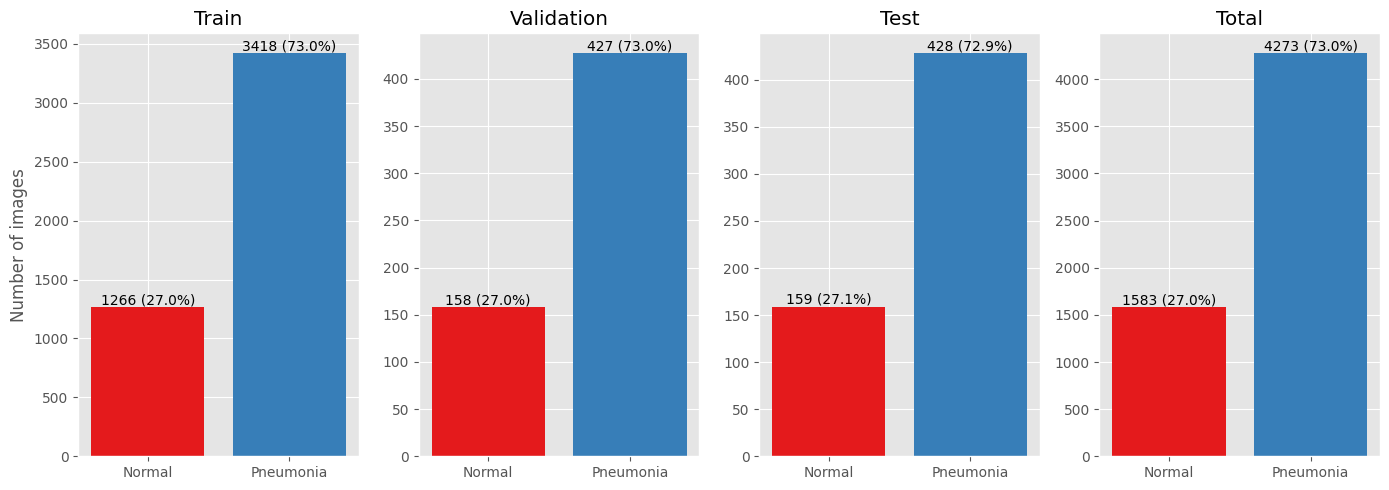

In [9]:
plot_label_distribution(new_train_path, new_val_path, new_test_path)

<h1 id="datasets-and-data-loaders" style="font-family:verdana;"> 
    <center>
        Creating Datasets and Dataloaders for Training
    </center>
</h1>

In [10]:
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 16
NUM_WORKERS = 4
DATA_TYPES = ['train', 'val', 'test']

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomVerticalFlip(p=0.2),
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.4822, 0.4822, 0.4822], [0.2362, 0.2362, 0.2362])
    ]),
    'val': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.4822, 0.4822, 0.4822], [0.2362, 0.2362, 0.2362])
    ]),
    'test': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.4822, 0.4822, 0.4822], [0.2362, 0.2362, 0.2362])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(new_dataset_path, x), data_transforms[x]) for x in DATA_TYPES}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) for x in DATA_TYPES}
dataset_sizes = {x: len(image_datasets[x]) for x in DATA_TYPES}
class_names = image_datasets['train'].classes

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
class Trainer:
    def __init__(
        self,
        device: str,
        model: torch.nn.Module,
        criterion: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        scheduler: torch.optim.lr_scheduler,
        train_dataloader: DataLoader,
        val_dataloader: DataLoader,
        test_dataloader: DataLoader,
        checkpoint_path: str,
        pneumonia_samples: str
    ):
        self.device = device
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.test_dataloader = test_dataloader
        self.checkpoint_path = checkpoint_path
        self.best_accuracy = 0.0
        self.best_model_path = None
        self.pneumonia_samples = pneumonia_samples
        
    def save_cam_samples(self, model: models.resnet.ResNet, epoch_nr: int) -> None:
        targets = [1, 1, 1, 1, 1]
        
        target_layer = [model.Mixed_7c]
        cam = GradCAM(model=model, target_layers=target_layer)

        plt.rcParams['axes.grid'] = False

        for i, (image_path, target) in enumerate(zip(self.pneumonia_samples, targets)):
            image = Image.open(image_path).convert('RGB')
            image_tensor = transforms.ToTensor()(image).unsqueeze(0)
            
            image = transforms.ToTensor()(image)
            image = image.numpy().transpose((1, 2, 0))
            image = np.clip(image, 0, 1)
            
            targets = [ClassifierOutputTarget(target)]
            grayscale_cam = cam(input_tensor=image_tensor, targets=targets)
            grayscale_cam = grayscale_cam[0, :]

            visualization = show_cam_on_image(np.array(image_tensor[0].permute(1, 2, 0)), grayscale_cam, use_rgb=True)

            filename = image_path.split('/')[-1].split('.')[0]
            filetype = image_path.split('/')[-1].split('.')[1]
            plt.imshow(visualization)
            plt.axis('off') 
            plt.savefig(f'samples/{filename}-cam-epoch-{epoch_nr}.{filetype}', bbox_inches='tight', pad_inches=0)
            plt.close()

    def train(self, current_epoch_nr: int) -> Tuple[float, float]:
        self.model.train()

        num_batches = len(self.train_dataloader)

        running_loss = 0.0
        n_corrects = 0
        total = 0
        
        if current_epoch_nr == 1:
            self.save_cam_samples(self.model, 0)

        loop = tqdm(self.train_dataloader, total=num_batches)
        for batch in loop:
            x, y = batch
            x, y = x.to(self.device), y.to(self.device)

            self.optimizer.zero_grad()

            y_hat = self.model(x)
            _, preds = torch.max(y_hat, 1)
            loss = self.criterion(y_hat, y)

            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * x.size(0)
            n_corrects += torch.sum(preds == y.data).data.item()
            total += y.size(0)

            loop.set_description(f'Epoch {current_epoch_nr}')
            loop.set_postfix(train_acc=round(n_corrects / total, 5),
                             train_loss=round(running_loss / total, 5))
            
        self.scheduler.step()

        train_accuracy = n_corrects / total
        train_loss = running_loss / num_batches

        return train_accuracy, train_loss

    def evaluate(self, current_epoch_nr: int) -> Tuple[float, float]:
        self.model.eval()

        num_batches = len(self.val_dataloader)

        running_loss = 0.0
        n_corrects = 0
        total = 0

        with torch.no_grad():
            loop = tqdm(self.val_dataloader, total=num_batches)
            for batch in loop:
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)

                self.optimizer.zero_grad()

                y_hat = self.model(x)
                _, preds = torch.max(y_hat, 1)
                loss = self.criterion(y_hat, y)

                running_loss += loss.item() * x.size(0)
                n_corrects += torch.sum(preds == y.data).data.item()
                total += y.size(0)
                

                loop.set_description(f'Epoch {current_epoch_nr}')
                loop.set_postfix(val_acc=round(n_corrects / total, 5),
                                 val_loss=round(running_loss / total, 5))

        val_accuracy = n_corrects / total
        val_loss = running_loss / num_batches

        self.save_cam_samples(self.model, current_epoch_nr)
        if val_accuracy > self.best_accuracy:
            self.best_accuracy = val_accuracy
            checkpoint_name = f'epoch_{current_epoch_nr}_acc_{round(val_accuracy, 2)}.pth'
            torch.save(
                self.model.state_dict(),
                os.path.join(self.checkpoint_path, checkpoint_name)
            )
            self.best_model_path = os.path.join(self.checkpoint_path, checkpoint_name)

        return val_accuracy, val_loss

    def test(self) -> Tuple[float, float, list, list, models.resnet.ResNet]:
        self.model.eval()

        num_batches = len(self.test_dataloader)

        running_loss = 0.0
        n_corrects = 0
        total = 0
        
        targets = []
        predictions = []

        with torch.no_grad():
            loop = tqdm(self.test_dataloader, total=num_batches)
            for batch in loop:
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)

                y_hat = self.model(x)
                _, preds = torch.max(y_hat, 1)
                loss = self.criterion(y_hat, y)

                running_loss += loss.item() * x.size(0)
                n_corrects += torch.sum(preds == y.data).data.item()
                total += y.size(0)
                
                targets.extend(y.cpu().numpy())
                predictions.extend(preds.cpu().numpy())

                loop.set_description('Testing')
                loop.set_postfix(test_acc=round(n_corrects / total, 5),
                                 test_loss=round(running_loss / total, 5))

        test_accuracy = n_corrects / total
        test_loss = running_loss / num_batches
        
        print('\nTest Accuracy: ', test_accuracy)
        print('Test Loss: ', test_loss)

        self.model.load_state_dict(torch.load(self.best_model_path))
        
        return test_accuracy, test_loss, targets, predictions, self.model
    
# I will use these samples to visualize with Grad-CAM
pneumonia_samples = [
    new_test_path + 'PNEUMONIA/person548_bacteria_2300.jpeg',
    new_test_path + 'PNEUMONIA/person1016_virus_1704.jpeg',
    new_test_path + 'PNEUMONIA/person1308_bacteria_3285.jpeg',
    new_test_path + 'PNEUMONIA/person1472_bacteria_3833.jpeg',
    new_test_path + 'PNEUMONIA/person305_bacteria_1436.jpeg'
]
os.makedirs('samples', exist_ok=True)
for sample in pneumonia_samples:
    img = Image.open(sample)
    img.save('samples/' + sample.split('/')[-1])

<h1 id="training" style="font-family:verdana;"> 
    <center>
        Training
    </center>
</h1>

## Key Points about InceptionV3:

1. **Architecture:** InceptionV3 is a convolutional neural network (CNN) architecture designed by Google. It is an extension of the original Inception architecture, incorporating various improvements to enhance performance and efficiency, including label smoothing, factorized 7x7 convolutions, and the use of an auxiliary classifer to propagate label information lower down the network. The InceptionV3 architecture consists of 48 layers, including convolutional, pooling, and fully connected layers. Its depth enables it to capture intricate patterns and features in input images.

3. **Inception Modules:** The hallmark of InceptionV3 is its extensive use of "Inception modules." These modules consist of parallel convolutional layers of different kernel sizes and are designed to capture features at multiple spatial scales efficiently.

4. **Computational Efficiency:** InceptionV3 employs various techniques to improve computational efficiency, such as factorized convolutions, which reduce the number of parameters and computational cost without sacrificing performance. It has demonstrated state-of-the-art performance on various computer vision tasks, including image classification and object detection, achieving high accuracy and efficiency compared to earlier architectures.

5. **Pre-training:** InceptionV3 is pre-trained on large-scale image datasets, such as ImageNet, using millions of labeled images. Pre-training enables the network to learn general features from diverse visual data, which can then be fine-tuned for specific tasks like object detection or image classification, or in this case detection of Pneumonia in chest X-rays. Due to its pre-trained nature, InceptionV3 is often used as a base model for transfer learning. Transfer learning involves leveraging the knowledge learned by the network during pre-training and fine-tuning it on a smaller dataset for a specific task, such as medical image analysis or object recognition.


In [12]:
model = models.inception_v3()
n_features = model.fc.in_features
model.fc = nn.Linear(n_features, len(class_names))
model.aux_logits = False
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [13]:
max_epochs = 10

train_dataloader = dataloaders['train']
val_dataloader = dataloaders['val']
test_dataloader = dataloaders['test']

checkpoint_path = '/kaggle/working/checkpoints'
try:
    os.mkdir(checkpoint_path)
except FileExistsError:
    pass


trainer = Trainer(
    device=device,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    checkpoint_path=checkpoint_path,
    pneumonia_samples=pneumonia_samples
)

histories = []
for epoch in range(1, max_epochs + 1):
    train_acc, train_loss = trainer.train(current_epoch_nr=epoch)
    val_acc, val_loss = trainer.evaluate(current_epoch_nr=epoch)
    
    histories.append({
        'epoch': epoch,
        'train_acc': train_acc,
        'train_loss': train_loss,
        'val_acc': val_acc,
        'val_loss': val_loss
    })

test_acc, test_loss, targets, predictions, best_model = trainer.test()

Testing: 100%|██████████| 37/37 [00:05<00:00,  7.23it/s, test_acc=0.951, test_loss=0.131]



Test Accuracy:  0.9505962521294719
Test Loss:  2.0820563395281098


<h1 id="results" style="font-family:verdana;"> 
    <center>
        Analyzing the Resulsts
    </center>
</h1>

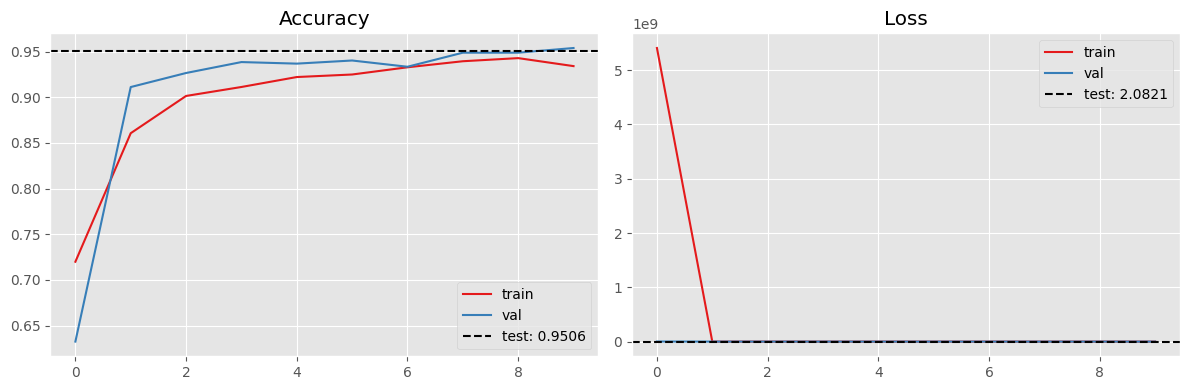

In [14]:
train_accs = [x['train_acc'] for x in histories]
train_losses = [x['train_loss'] for x in histories]
val_accs = [x['val_acc'] for x in histories]
val_losses = [x['val_loss'] for x in histories]

plt.rcParams['axes.grid'] = True
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_accs, label='train', color=colors[0])
plt.plot(val_accs, label='val', color=colors[1])
plt.axhline(y=test_acc, color='black', linestyle='--', label=f'test: {test_acc:.4f}')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='train', color=colors[0])
plt.plot(val_losses, label='val', color=colors[1])
plt.axhline(y=test_loss, color='black', linestyle='--', label=f'test: {test_loss:.4f}')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

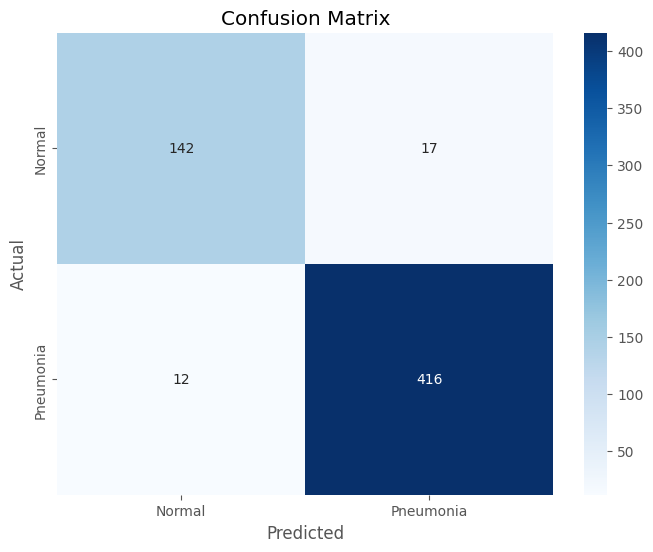

In [15]:
cm = confusion_matrix(targets, predictions)

plt.rcParams['axes.grid'] = False
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [16]:
print(classification_report(targets, predictions, target_names=['Normal', 'Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.92      0.89      0.91       159
   Pneumonia       0.96      0.97      0.97       428

    accuracy                           0.95       587
   macro avg       0.94      0.93      0.94       587
weighted avg       0.95      0.95      0.95       587



<h1 id="gradcam" style="font-family:verdana;"> 
    <center>
        Grad-CAM
    </center>
</h1>

In [17]:
def plot_cam(model: models.resnet.ResNet, image_paths: list, targets: list) -> None:
    model = model.eval()
    
    target_layer = [model.Mixed_7c]
    cam = GradCAM(model=model, target_layers=target_layer)

    plt.rcParams['axes.grid'] = False
    fig, axs = plt.subplots(2, 4, figsize=(14, 7))

    for i, (image_path, target) in enumerate(zip(image_paths, targets)):
        image = Image.open(image_path).convert('RGB')
        image = transforms.ToTensor()(image)
        
        image_tensor = image.unsqueeze(0)
        
        image = image.numpy().transpose((1, 2, 0))
        image = np.clip(image, 0, 1)
        
        targets = [ClassifierOutputTarget(target)]
        grayscale_cam = cam(input_tensor=image_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]

        visualization = show_cam_on_image(np.array(image_tensor[0].permute(1, 2, 0)), grayscale_cam, use_rgb=True)

        axs[1, i].imshow(image)
        axs[1, i].set_title('Original')
        axs[1, i].tick_params(axis='both', which='major', labelsize=6)

        axs[0, i].imshow(visualization)
        axs[0, i].set_title('Grad-CAM')
        axs[0, i].tick_params(axis='both', which='major', labelsize=6)

    plt.tight_layout()
    plt.show()

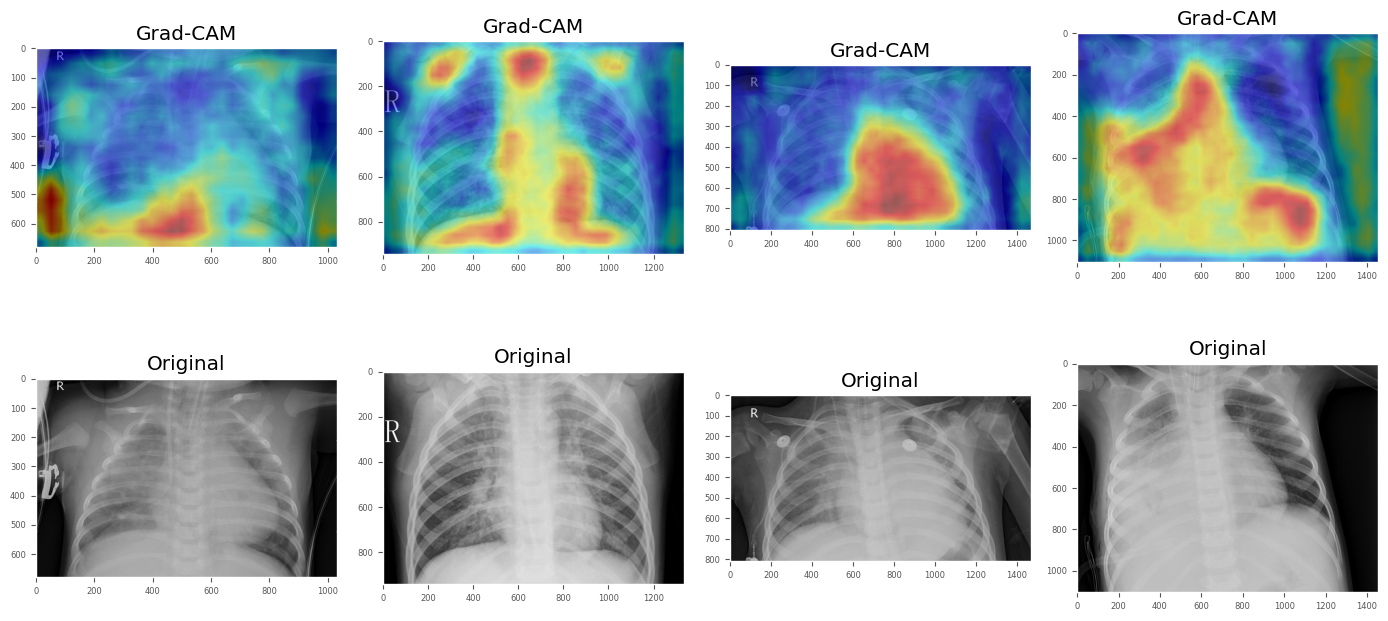

In [18]:
image_paths = pneumonia_samples
plot_cam(best_model, image_paths, [1] * 4)

- The plot above showcases chest X-rays of five smaple images and their CAM visualizations. In the bottom row, images containing pneumonia are displayed in their original form. The top row of the plot shows CAM visualizations corresponding to the same set of images. CAM highlights the regions within the X-ray images that the model identifies as indicative of pneumonia, aiding in the interpretation of the model's decision-making process and providing insights into areas of interest for diagnosis. Since, I'm not expert, I cannot tell whether the model is looking at the correct spots in the images, however it is not difficult to notice that in some of the images the model actually focuses on dark spots, even the background.
- The plot below illustrates the learning progress of the model across multiple epochs. Each subplot within the plot represents the CAM result for the same chest X-ray image at different stages of training, spanning from the initial state (before any training) to the completion of ten epochs. By visualizing the CAM results at various epochs, the plot offers a dynamic depiction of how the model's understanding of pneumonia-related features evolves over the course of training. This progression provides insights into the model's learning trajectory and highlights the refinement of its predictive capabilities over successive epochs.

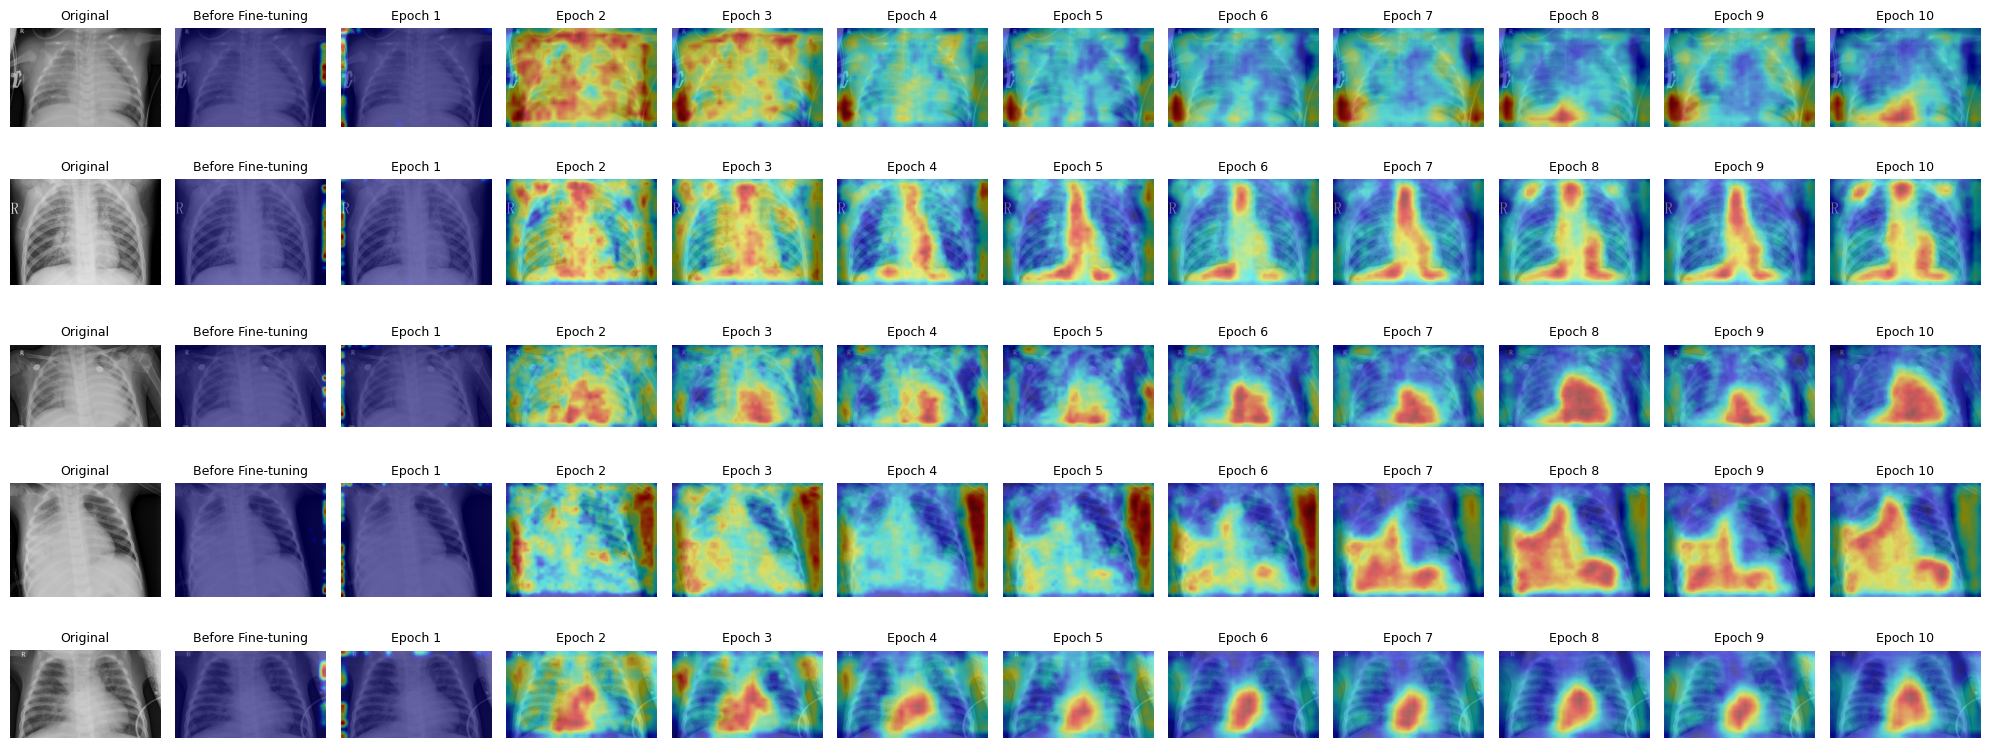

In [19]:
fig, axs = plt.subplots(len(pneumonia_samples), max_epochs + 2, figsize=(20, 8))
start_index = 0
for row in range(len(pneumonia_samples)):
    filename = Image.open(pneumonia_samples[start_index])
    axs[row, 0].imshow(filename, cmap='gray')
    axs[row, 0].set_title('Original', fontsize=9)
    axs[row, 0].axis('off')
    start_index += 1

    original_filename = filename.filename.split('/')[-1].split('.')[0]

    for col in range(1, max_epochs + 2):
        filename = Image.open(f'/kaggle/working/samples/{original_filename}-cam-epoch-{col-1}.jpeg')
        axs[row, col].imshow(filename, cmap='gray')
        if col == 0:
            title = 'Original'
        if col == 1:
            title = 'Before Fine-tuning'
        if col > 1:
            title = f'Epoch {col - 1}'
        axs[row, col].set_title(title, fontsize=9)
        axs[row, col].axis('off')


plt.tight_layout()
plt.savefig("cover.png")
plt.show()